# Dam-AEI Targeting Ratio Analysis (GDW Dataset, by Aridity Layer)

This notebook analyzes the targeting ratio between dams and irrigated areas using the GDW dataset, broken down by aridity layer (All, Semi-Arid, Arid, Hyper-Arid). Targeting ratios are calculated using country-specific denominators for full comparability with the other analysis.

## 1. Import Libraries and Utility Functions
Import all required libraries and utility functions for spatial analysis, configuration, and plotting.

In [ ]:
# Import required libraries and utility functions
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.mask import mask
from scipy.spatial import cKDTree
import os
import sys

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path
from Code.utils.spatial_utility import load_and_reproject, bootstrap_targeting_ratio, calculate_nearest_distances, generate_distance_ranges

# Load configuration
config = load_config()
layers = ['All', 'Semi_Arid', 'Arid', 'Hyper_Arid']
distance_ranges = generate_distance_ranges(min_dist=0, max_dist=100000, num_intervals=10)

## 2. Generate Distance Ranges
Create distance intervals for classifying proximity to dams.

In [27]:
# Generate 10 intervals between 0 and 100,000 meters for distance classification
# (e.g., 0-10km, 10-20km, ...)
distance_ranges = generate_distance_ranges(min_dist=0, max_dist=100000, num_intervals=10)
print("Distance ranges:", distance_ranges)

Distance ranges: [(0.0, 10000.0), (10000.0, 20000.0), (20000.0, 30000.0), (30000.0, 40000.0), (40000.0, 50000.0), (50000.0, 60000.0), (60000.0, 70000.0), (70000.0, 80000.0), (80000.0, 90000.0), (90000.0, 100000.0)]


## 3. Load and Prepare Input Data
Load and reproject dam, AEI, and CPIS data. Clip dams to arid SSA boundary.

In [28]:
try:
    # Load and reproject dam, AEI, and CPIS data
    gdf_dams = load_and_reproject(config['GDW_Arid_SSA_Final_shp_path'])
    gdf_arid_ssa = load_and_reproject(config['SSA_Arid_by_Country_shp_path'])
    gdf_AEI = load_and_reproject(config['AEI_2015_All_shp_path'])
    gdf_cpis = load_and_reproject(config['SSA_Combined_CPIS_All_shp_path'])
    
    print(f"Dams in arid SSA: {len(gdf_dams)}")
    print(f"AEI polygons in arid SSA: {len(gdf_AEI)}")
    print(f"CPIS polygons in arid SSA: {len(gdf_cpis)}")
    
    # Clip dams to arid SSA boundary
    gdf_dams = gpd.clip(gdf_dams, gdf_arid_ssa)
    print(f"Dams in arid SSA after clipping: {len(gdf_dams)}")
except Exception as e:
    print(f"Error loading input data: {e}")

Dams in arid SSA: 2764
AEI polygons in arid SSA: 16920
CPIS polygons in arid SSA: 29493
Dams in arid SSA after clipping: 2764
Dams in arid SSA after clipping: 2764


## 4. Process AEI Raster Data
Mask AEI raster to arid SSA and convert to point grid for analysis.

In [29]:
try:
    # Load AEI raster data and mask to arid SSA
    aei_raster_path = resolve_path(config['Africa_AEI_2015_asc_path'])
    with rasterio.open(aei_raster_path) as src:
        aei_crs = src.crs or rasterio.crs.CRS.from_epsg(4326)
    gdf_arid_ssa = gdf_arid_ssa.to_crs(aei_crs)
    with rasterio.open(aei_raster_path) as src:
        aei_masked, aei_transform = mask(src, gdf_arid_ssa.geometry, crop=True)
        aei_data = aei_masked[0]
    print(f"Loaded and masked AEI raster data with shape {aei_data.shape}")
except Exception as e:
    print(f"Error processing AEI raster data: {e}")

Loaded and masked AEI raster data with shape (746, 828)


## 5. Convert Raster to Points
Convert nonzero AEI raster pixels to point geometries for distance calculations.

In [30]:
def raster_to_points(aei_array, transform):
    """Convert a raster array to a set of points for non-zero values."""
    if aei_array.ndim == 3:
        aei_array = np.squeeze(aei_array, axis=0)
    rows, cols = np.where(aei_array > 0)
    xs, ys = rasterio.transform.xy(transform, rows, cols)
    return np.column_stack([xs, ys])

try:
    # Convert masked AEI pixels to point grid
    aei_points = raster_to_points(aei_masked, aei_transform)
    print(f"Converted AEI raster to {len(aei_points)} points")
    # Create a GeoDataFrame from the points
    aei_points_gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy(aei_points[:, 0], aei_points[:, 1]), 
        crs=aei_crs
    )
    # Reproject to match dam CRS
    aei_points_gdf = aei_points_gdf.to_crs(gdf_dams.crs)
    print(f"Reprojected AEI points to CRS: {aei_points_gdf.crs}")
except Exception as e:
    print(f"Error converting raster to points: {e}")

Converted AEI raster to 11238 points
Reprojected AEI points to CRS: EPSG:3857


## 6. Calculate Distances and Classify
Compute distances from AEI points and CPIS centroids to nearest dams, and classify by distance range.

In [31]:
try:
    # Calculate distances from AEI points to nearest dams
    aei_coords = np.array([(pt.x, pt.y) for pt in aei_points_gdf.geometry])
    dam_coords = np.array([(pt.x, pt.y) for pt in gdf_dams.geometry])
    tree = cKDTree(dam_coords)
    distances, _ = tree.query(aei_coords)
    # Proportion of irrigated pixels in each distance range
    def classify_by_distance(distances, distance_ranges):
        proportions = {}
        total = len(distances)
        for lower, upper in distance_ranges:
            label = f"{int(lower)}-{int(upper)}"
            count = np.sum((distances >= lower) & (distances < upper))
            proportions[label] = count / total if total > 0 else 0
        return proportions
    proportion_irrigated_pixels = classify_by_distance(distances, distance_ranges)
    print("Classified AEI points by distance to nearest dam")
    # Calculate distances from CPIS centroids to nearest dams
    cpis_centroids = np.array([(geom.centroid.x, geom.centroid.y) for geom in gdf_cpis.geometry])
    cpis_tree = cKDTree(dam_coords)
    cpis_distances, _ = cpis_tree.query(cpis_centroids)
    gdf_cpis['dam_distance'] = cpis_distances
    # Classify CPIS by distance
    cpis_classification = {}
    for lower, upper in distance_ranges:
        label = f"{int(lower)}-{int(upper)}"
        gdf_cpis[label] = ((gdf_cpis['dam_distance'] >= lower) & (gdf_cpis['dam_distance'] < upper)).astype(int)
        cpis_classification[label] = gdf_cpis[label]
    print("Classified CPIS points by distance to nearest dam")
except Exception as e:
    print(f"Error calculating distances and classifying: {e}")

Classified AEI points by distance to nearest dam
Classified CPIS points by distance to nearest dam
Classified CPIS points by distance to nearest dam


## 7. Calculate Targeting Ratios
Compute targeting ratios and confidence intervals for each distance range.

In [32]:
try:
    # Calculate targeting ratios for each distance range
    targeting_ratios = {}
    confidence_intervals = {}
    for label in cpis_classification.keys():
        numerator = gdf_cpis[label].sum()
        denominator = proportion_irrigated_pixels.get(label, 0) * len(gdf_cpis)
        if denominator > 0:
            ratio = numerator / denominator
            ci_low, ci_high = bootstrap_targeting_ratio(numerator, denominator)
        else:
            ratio, ci_low, ci_high = np.nan, np.nan, np.nan
        targeting_ratios[label] = ratio
        confidence_intervals[label] = (ci_low, ci_high)
    print("Calculated initial targeting ratios")
except Exception as e:
    print(f"Error calculating targeting ratios: {e}")

Calculated initial targeting ratios


## 8. Calculate Country-Specific Distances and Proportions
Classify CPIS by nearest dam distance and calculate irrigated pixel proportions by country.

In [33]:
try:
    # Calculate nearest dam distances for CPIS
    gdf_cpis['nearest_dam_distance'] = calculate_nearest_distances(gdf_cpis, gdf_dams)
    # Classify CPIS into distance ranges
    for (lower, upper) in distance_ranges:
        label = f"{int(lower)}-{int(upper)}"
        gdf_cpis[f'dist_{label}'] = ((gdf_cpis['nearest_dam_distance'] >= lower) & 
                                     (gdf_cpis['nearest_dam_distance'] < upper)).astype(int)
    print("Classified CPIS by nearest dam distance")

    # Calculate proportion of irrigated pixels by country
    proportions_by_country = {}
    for iso3 in gdf_AEI['ISO'].unique():
        aei_country = gdf_AEI[gdf_AEI['ISO'] == iso3]
        dams_country = gdf_dams[gdf_dams['ISO'] == iso3]
        distances = calculate_nearest_distances(aei_country, dams_country)
        total_pixels = len(aei_country)
        proportions = {}
        for (lower, upper) in distance_ranges:
            count = np.sum((distances >= lower) & (distances < upper))
            proportions[f'{int(lower)}-{int(upper)}'] = count / total_pixels if total_pixels > 0 else 0
        proportions_by_country[iso3] = proportions
    print("Calculated proportions by country")
except Exception as e:
    print(f"Error calculating country-specific distances: {e}")

Classified CPIS by nearest dam distance
Calculated proportions by country
Calculated proportions by country


## 9. Calculate Final Targeting Ratios (Country-Specific)
Compute targeting ratios using country-specific proportions for each distance range.

In [34]:
try:
    # Calculate targeting ratios using country-specific proportions
    targeting_ratios = {}
    confidence_intervals = {}
    for label in cpis_classification.keys():
        numerator = gdf_cpis[f'dist_{label}'].sum()
        denominator = 0
        for iso3 in gdf_cpis['Country Co'].unique():
            cpis_count = np.sum(gdf_cpis['Country Co'] == iso3)
            prop = proportions_by_country.get(iso3, {}).get(label, 0)
            denominator += cpis_count * prop
        if denominator > 0:
            ratio = numerator / denominator
            ci_low, ci_high = bootstrap_targeting_ratio(numerator, denominator)
        else:
            ratio, ci_low, ci_high = np.nan, np.nan, np.nan
        targeting_ratios[label] = ratio
        confidence_intervals[label] = (ci_low, ci_high)
    print("Calculated final targeting ratios")
except Exception as e:
    print(f"Error calculating final targeting ratios: {e}")

Calculated final targeting ratios


/tmp/ipykernel_3700528/1376003319.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


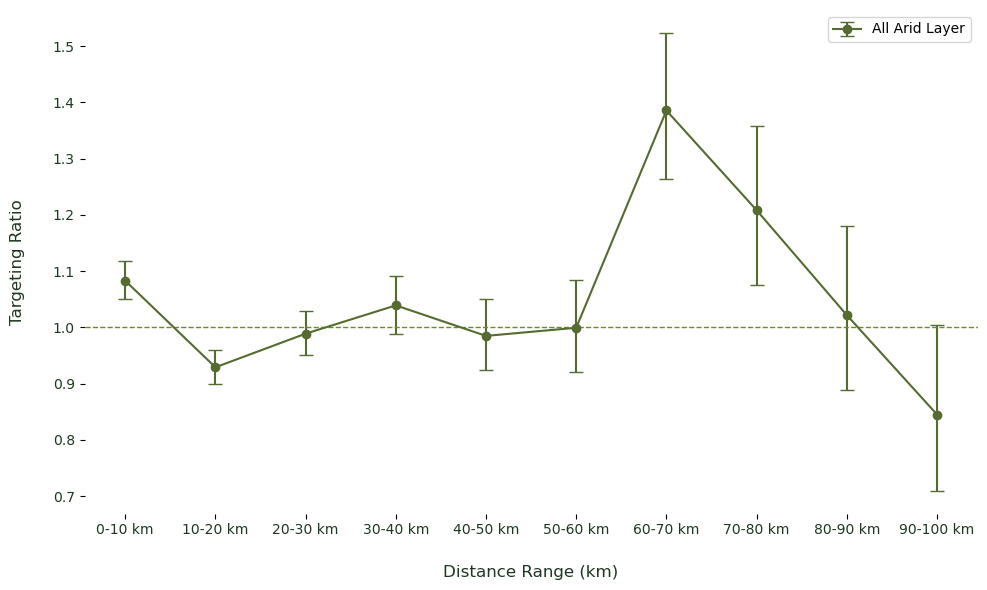

Plotted targeting ratios


In [35]:
def plot_targeting_ratios(targeting_ratios, confidence_intervals, output_path=None):
    """Plot targeting ratios with confidence intervals."""
    range_labels = sorted(targeting_ratios.keys(), key=lambda x: int(x.split('-')[0]))
    ratio_values = np.array([targeting_ratios[label] for label in range_labels])
    ci_lower = np.array([confidence_intervals[label][0] for label in range_labels])
    ci_upper = np.array([confidence_intervals[label][1] for label in range_labels])
    error = np.array([ratio_values - ci_lower, ci_upper - ratio_values])
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_facecolor('white')
    plt.gcf().set_facecolor('white')
    plt.errorbar(range_labels, ratio_values, yerr=error, fmt='-o', capsize=5, color='darkolivegreen', label='All Arid Layer')
    plt.axhline(y=1, color='olivedrab', linestyle='--', linewidth=1)
    ax.set_xticklabels([
        f"{int(r.split('-')[0])//1000}-{int(r.split('-')[1])//1000} km" for r in range_labels
    ])
    plt.xlabel('Distance Range (km)', fontsize=12, labelpad=20, color='#1E3720')
    plt.ylabel('Targeting Ratio', fontsize=12, labelpad=20, color='#1E3720')
    plt.xticks(color='#1E3720')
    plt.yticks(color='#1E3720')
    plt.legend()
    plt.tight_layout()
    if output_path:
        plt.savefig(output_path)
    plt.show()

try:
    # Plot the targeting ratios
    plot_targeting_ratios(targeting_ratios, confidence_intervals)
    print("Plotted targeting ratios")
except Exception as e:
    print(f"Error plotting targeting_ratios: {e}")

## Calculate Targeting Ratios and Confidence Intervals by Aridity Layer (In progress)

This cell calculates targeting ratios and confidence intervals for each aridity layer using country-specific denominators, following the logic from the 3_Dams_AEI_Targeting_Ratios analysis. The only difference is that the dam dataset used here is the GDW dataset. All country code columns are harmonized as 'ISO' for consistency.

In [38]:
targeting_ratios_by_layer = {}
confidence_intervals_by_layer = {}

for layer in layers:
    try:
        # Load and reproject data for this aridity layer
        gdf_dams = load_and_reproject(config[f'GDW_{layer}_SSA_Final_shp_path'])
        print(gdf_dams.columns)
        gdf_AEI = load_and_reproject(config[f'AEI_2015_{layer}_shp_path'])
        print(gdf_AEI.columns)
        gdf_cpis = load_and_reproject(config[f'SSA_Combined_CPIS_{layer}_shp_path'])
        print(gdf_cpis.columns)
        # Harmonize country code column
        if 'Country Co' in gdf_cpis.columns:
            gdf_cpis = gdf_cpis.rename(columns={'Country Co': 'ISO'})
        # Calculate nearest dam distances for CPIS
        gdf_cpis['nearest_dam_distance'] = calculate_nearest_distances(gdf_cpis, gdf_dams)
        # Classify CPIS into distance ranges
        for (lower, upper) in distance_ranges:
            label = f"{int(lower)}-{int(upper)}"
            gdf_cpis[f'dist_{label}'] = ((gdf_cpis['nearest_dam_distance'] >= lower) & 
                                         (gdf_cpis['nearest_dam_distance'] < upper)).astype(int)
        # Calculate proportion of irrigated pixels by country
        proportions_by_country = {}
        for iso3 in gdf_AEI['ISO'].unique():
            aei_country = gdf_AEI[gdf_AEI['ISO'] == iso3]
            dams_country = gdf_dams[gdf_dams['ISO'] == iso3]
            distances = calculate_nearest_distances(aei_country, dams_country)
            total_pixels = len(aei_country)
            proportions = {}
            for (lower, upper) in distance_ranges:
                count = np.sum((distances >= lower) & (distances < upper))
                proportions[f'{int(lower)}-{int(upper)}'] = count / total_pixels if total_pixels > 0 else 0
            proportions_by_country[iso3] = proportions
        # Calculate targeting ratios for this layer
        targeting_ratios = {}
        confidence_intervals = {}
        for (lower, upper) in distance_ranges:
            label = f"{int(lower)}-{int(upper)}"
            numerator = gdf_cpis[f'dist_{label}'].sum()
            denominator = 0
            for iso3 in gdf_cpis['ISO'].unique():
                cpis_count = np.sum(gdf_cpis['ISO'] == iso3)
                prop = proportions_by_country.get(iso3, {}).get(label, 0)
                denominator += cpis_count * prop
            if denominator > 0:
                ratio = numerator / denominator
                ci_low, ci_high = bootstrap_targeting_ratio(numerator, denominator)
            else:
                ratio, ci_low, ci_high = np.nan, np.nan, np.nan
            targeting_ratios[label] = ratio
            confidence_intervals[label] = (ci_low, ci_high)
        targeting_ratios_by_layer[layer] = targeting_ratios
        confidence_intervals_by_layer[layer] = confidence_intervals
        print(f"Processed layer: {layer}")
    except Exception as e:
        print(f"Error processing layer {layer}: {e}")


Error processing layer All: 'GDW_All_SSA_Final_shp_path'
Error processing layer Semi_Arid: 'GDW_Semi_Arid_SSA_Final_shp_path'
Index(['GDW_ID', 'RES_NAME', 'DAM_NAME', 'ALT_NAME', 'DAM_TYPE', 'LAKE_CTRL',
       'RIVER', 'ALT_RIVER', 'MAIN_BASIN', 'SUB_BASIN', 'COUNTRY', 'SEC_CNTRY',
       'ADMIN_UNIT', 'SEC_ADMIN', 'NEAR_CITY', 'ALT_CITY', 'YEAR_DAM',
       'PRE_YEAR', 'YEAR_SRC', 'ALT_YEAR', 'REM_YEAR', 'TIMELINE', 'YEAR_TXT',
       'DAM_HGT_M', 'ALT_HGT_M', 'DAM_LEN_M', 'ALT_LEN_M', 'AREA_SKM',
       'AREA_POLY', 'AREA_REP', 'AREA_MAX', 'AREA_MIN', 'CAP_MCM', 'CAP_MAX',
       'CAP_REP', 'CAP_MIN', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL',
       'CATCH_SKM', 'CATCH_REP', 'POWER_MW', 'DATA_INFO', 'USE_IRRI',
       'USE_ELEC', 'USE_SUPP', 'USE_FCON', 'USE_RECR', 'USE_NAVI', 'USE_FISH',
       'USE_PCON', 'USE_LIVE', 'USE_OTHR', 'MAIN_USE', 'MULTI_DAMS',
       'COMMENTS', 'URL', 'QUALITY', 'EDITOR', 'LONG_RIV', 'LAT_RIV',
       'LONG_DAM', 'LAT_DAM', 'ORIG_SRC', 'POLY_SRC'

## 11. Visualize Targeting Ratios by Aridity Layer
Plot targeting ratios for all aridity layers on a single figure for direct comparison.

In [ ]:
def plot_targeting_ratios_by_layer(targeting_ratios_by_layer, confidence_intervals_by_layer):
    plt.figure(figsize=(12, 7))
    for layer, ratios in targeting_ratios_by_layer.items():
        range_labels = sorted(ratios.keys(), key=lambda x: int(x.split('-')[0]))
        ratio_values = np.array([ratios[label] for label in range_labels])
        ci_lower = np.array([confidence_intervals_by_layer[layer][label][0] for label in range_labels])
        ci_upper = np.array([confidence_intervals_by_layer[layer][label][1] for label in range_labels])
        error = np.array([ratio_values - ci_lower, ci_upper - ratio_values])
        plt.errorbar(
            [f"{int(r.split('-')[0])//1000}-{int(r.split('-')[1])//1000} km" for r in range_labels],
            ratio_values, yerr=error, fmt='-o', capsize=5, label=layer)
    plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
    plt.xlabel('Distance Range (km)')
    plt.ylabel('Targeting Ratio')
    plt.title('Targeting Ratios by Distance to Dam and Aridity Layer')
    plt.legend(title='Aridity Layer')
    plt.tight_layout()
    plt.show()

# Calculate targeting ratios and confidence intervals for all aridity layers
# This cell must be run before plotting

targeting_ratios_by_layer = {}
confidence_intervals_by_layer = {}

for layer in layers:
    # Load and reproject data for this aridity layer
    # (Assume file paths in config are keyed by layer name, e.g., 'GDW_Arid_SSA_Final_shp_path', etc.)
    try:
        gdf_dams = load_and_reproject(config[f'GDW_{layer}_SSA_Final_shp_path'])
        gdf_arid_ssa = load_and_reproject(config[f'SSA_{layer}_by_Country_shp_path'])
        gdf_AEI = load_and_reproject(config[f'AEI_2015_{layer}_shp_path'])
        gdf_cpis = load_and_reproject(config[f'SSA_Combined_CPIS_{layer}_shp_path'])
        # Harmonize country code column
        if 'Country Co' in gdf_cpis.columns:
            gdf_cpis = gdf_cpis.rename(columns={'Country Co': 'ISO'})
        # Calculate nearest dam distances for CPIS
        gdf_cpis['nearest_dam_distance'] = calculate_nearest_distances(gdf_cpis, gdf_dams)
        # Classify CPIS into distance ranges
        for (lower, upper) in distance_ranges:
            label = f"{int(lower)}-{int(upper)}"
            gdf_cpis[f'dist_{label}'] = ((gdf_cpis['nearest_dam_distance'] >= lower) & 
                                         (gdf_cpis['nearest_dam_distance'] < upper)).astype(int)
        # Calculate proportion of irrigated pixels by country
        proportions_by_country = {}
        for iso3 in gdf_AEI['ISO'].unique():
            aei_country = gdf_AEI[gdf_AEI['ISO'] == iso3]
            dams_country = gdf_dams[gdf_dams['ISO'] == iso3]
            distances = calculate_nearest_distances(aei_country, dams_country)
            total_pixels = len(aei_country)
            proportions = {}
            for (lower, upper) in distance_ranges:
                count = np.sum((distances >= lower) & (distances < upper))
                proportions[f'{int(lower)}-{int(upper)}'] = count / total_pixels if total_pixels > 0 else 0
            proportions_by_country[iso3] = proportions
        # Calculate targeting ratios for this layer
        targeting_ratios = {}
        confidence_intervals = {}
        for (lower, upper) in distance_ranges:
            label = f"{int(lower)}-{int(upper)}"
            numerator = gdf_cpis[f'dist_{label}'].sum()
            denominator = 0
            for iso3 in gdf_cpis['ISO'].unique():
                cpis_count = np.sum(gdf_cpis['ISO'] == iso3)
                prop = proportions_by_country.get(iso3, {}).get(label, 0)
                denominator += cpis_count * prop
            if denominator > 0:
                ratio = numerator / denominator
                ci_low, ci_high = bootstrap_targeting_ratio(numerator, denominator)
            else:
                ratio, ci_low, ci_high = np.nan, np.nan, np.nan
            targeting_ratios[label] = ratio
            confidence_intervals[label] = (ci_low, ci_high)
        targeting_ratios_by_layer[layer] = targeting_ratios
        confidence_intervals_by_layer[layer] = confidence_intervals
        print(f"Processed layer: {layer}")
    except Exception as e:
        print(f"Error processing layer {layer}: {e}")

# Call this after all targeting_ratios_by_layer and confidence_intervals_by_layer are computed
plot_targeting_ratios_by_layer(targeting_ratios_by_layer, confidence_intervals_by_layer)

NameError: name 'targeting_ratios_by_layer' is not defined